In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import matplotlib as mpl
import random
from random import randrange
import statistics as st

In [2]:
nrows = 1000000 #количество обменов
    
a = np.random.randint(500, 20000, size=(nrows, 1)) #сколько дает клиент - диапазон
b = np.random.randint(2, size=(nrows, 1)) #какую валюту дает клиент
c = np.zeros(nrows, int) #какую валюту отдаем клиенту 

for i in range(0, nrows): 
    c[i] = 1 - b[i]

In [3]:
df = pd.DataFrame(a, columns = ['amount'])
df['take'] = b
df['give'] = c

In [4]:
Ut = np.zeros(nrows) 
etc_course = np.zeros(nrows, float)

s = []
p = 0.5

for i in range(0,nrows):
    s += random.choices([1, -1], weights=[p, 1-p])
    Ut[i] = s[i]
    
delta = 0.001

etc_course[0] = 2300 #usd

for i in range(1,nrows):
    etc_course[i] = etc_course[i-1]*math.exp(delta*Ut[i-1]) 

In [5]:
#dt[i] - разница времени прихода i и i-1 клиента
dt = np.random.randint(1, 100, size=(nrows, 1))

In [6]:
Slippage_u = np.zeros(nrows, float)
Slippage_s = np.zeros(nrows, float)

In [7]:
def gas_fee(dt, i, j):
    
    max_gas_price = 50 #max gwei
    min_gas_price = 5
    
    k = 0.202
    
    if dt > math.exp((max_gas_price - min_gas_price)*k) - 1:
        res = min_gas_price
    else: 
        res = max_gas_price - math.log(dt)/k
    
    gas_used = 0
    
    if j == 0: gas_used = 100000 #gwei
    if j == 1: gas_used = 250000
  
    res = res*gas_used
    
    res /= 1000000000 #etc
    
    res *= etc_course[i] #usd
    
    if j == 2: res = 9
    else: res = 13
    
    return res

In [8]:
#stableswap parameters

A = 85
n = 2
D = 0

X = np.zeros(n, float) #кол-во валют 1 и 2 типа

for i in range(0,n):
    X[i] = 10000000
    D += X[i]

In [9]:
#кол-ва stableswap

X1 = np.zeros(nrows+1)
X2 = np.zeros(nrows+1)
X1[0] = X[0]
X2[0] = X[1]

In [10]:
Course_Stableswap = np.zeros(nrows+1, float)
Course_UniswapV3 = np.zeros(nrows+1, float)

Course_Stableswap[0] = 1
Course_UniswapV3[0] = 1

In [11]:
def F(X, x, i):
    L = D**(n+1)/n**(n)
    for j in range(0,n):
        if j!=i:
            L /= X[j]
        else:
            L /= x**(2) 
    return A*n**(n) + L


def f(X, x, i):
    L = 0
    P = 1
    for j in range(0,n):
        if j!=i:
            L += X[j]
            P *= X[j]
        else:
            L += x
            P *= x
    return A*n**(n)*L + D - A*n**(n)*D - D**(n+1)/(n**(n)*P)


def Newton(X, i, k):
    
    # корень кв. ур-я
    
    if i == 0:
        b = (D/(A* n**(n)) - D + X[1])
        d = b**(2)+4*(D**(n+1)/(A*X[1]*n**(2*n)))
        d = d**(1/2)
        
        return (-b + d)/2
    else:
        b = (D/(A* n**(n)) - D + X[0])
        d = b**(2)+4*(D**(n+1)/(A*X[0]*n**(2*n)))
        d = d**(1/2)
        return (-b + d)/2
    '''
    # метод Ньютона
    
    x0 = X[i] - 2 * k
    x_prev = x0
    x_curr = x0 - f(X, x0, i)/F(X, x0, i)
    eps = 10**(-12)
    swap_value = 0
    while abs(x_prev - x_curr) > eps:
        swap_value = x_curr
        x_curr = x_prev - f(X, x_prev, i)/F(X, x_prev, i)
        x_prev = swap_value
    return x_curr'''

In [12]:
#stableswap

def Exchange(i, j, k, X):
       
        X[i] += k
        res = Newton(X, j, k)
        X[i] -= k
        
        return res

In [13]:
#Uniswap V3 parameters
n = 2

U = np.zeros(n)
C = np.zeros(n)

C[0] = 10000000
C[1] = 10000000

A1 = 1.01

U[0] = C[0] 
U[1] = C[1]

U1 = np.zeros(nrows+1)
U2 = np.zeros(nrows+1)

U1[0] = U[0]
U2[0] = U[1]

In [14]:
def UniswapV3_exchange(i, j, k, fee, U):
        
        u = U[i]+k*(1-fee)
            
        P = 1
        for l in range(0,n): 
            P*=C[l]
        
        res = A1*P/((1-A1**(1/2))**(2))
        res /= (u + C[i]/(A1**(1/2) - 1))
        
        for l in range(0,n): 
            if l!=i:
                res -= C[l]/(A1**(1/2) - 1)
    
        if res < 0: 
            return 0                                     
        
        return U[j] - res #delta

In [15]:
kx = 0 #кол-во обменов в Stableswap
ky = 0 #кол-во обменов в UniswapV3

sum_x = 0 #сумма комиссий в Stableswap
sum_y = 0 #сумма комиссий в UniswapV3

feex = 0.002 # % LP в Stableswap
feey = 0.0005 # % LP в UniswapV3

dtx = 0 #прошло времени с последнего обмена в Stableswap
dty = 0 #прошло времени с последнего обмена в UniswapV3

gasx_amt = 0 #сумма комиссий за газ в Stableswap
gasy_amt = 0 #сумма комиссий за газ в UniswapV3

countx = 0
county = 0

#course = dx0/dx1

eps = 10 ** (-12)

for i in range (0, nrows):
    
    if df['take'].iloc[i] != df['give'].iloc[i]:
       
        dx = X[df['give'].iloc[i]] - Exchange(df['take'].iloc[i], df['give'].iloc[i], df['amount'].iloc[i] * (1 - feex), X)
        dy = UniswapV3_exchange(df['take'].iloc[i], df['give'].iloc[i], df['amount'].iloc[i], feey, U)

        #dx = -100000000000
        
        dtx += dt[i]
        dty += dt[i]
       
        if dx - gas_fee(dtx, i, 0) > dy - (gas_fee(dty, i, 1)):
            
            Slippage_s[i] = df['amount'].iloc[i] * (1-feex)/(X[df['take'].iloc[i]]+eps)
            
            X[df['give'].iloc[i]] -= dx
            X[df['take'].iloc[i]] += df['amount'].iloc[i] * (1-feex)
            
            
            kx += 1
            sum_x += df['amount'].iloc[i] * (feex)
            countx += df['amount'].iloc[i] * (1-feex)
            
            gasx_amt += gas_fee(dtx, i, 0)
            
            Course_UniswapV3[i+1] = Course_UniswapV3[i]
            
            if df['give'].iloc[i] == 0:
                Course_Stableswap[i+1] = (df['amount'].iloc[i] * (1-feex)) / (dx + eps)
            else:
                Course_Stableswap[i+1] = dx / (df['amount'].iloc[i] * (1-feex) + eps)
                
            dtx = 0
        
        else:
            
            Slippage_u[i] = df['amount'].iloc[i] * (1-feex)/(U[df['take'].iloc[i]]+C[df['take'].iloc[i]]/(A**(1/2) - 1))
            
            U[df['give'].iloc[i]] -= dy
            U[df['take'].iloc[i]] += df['amount'].iloc[i] * (1-feey)
            
            ky+=1
            sum_y+=df['amount'].iloc[i] * (feey)
            county += df['amount'].iloc[i] * (1-feey)
            
            gasy_amt += gas_fee(dty, i, 1)
            
            Course_Stableswap[i+1] = Course_Stableswap[i]
            
            if df['give'].iloc[i] == 0:
                Course_UniswapV3[i+1] = (df['amount'].iloc[i] * (1-feey)) / (dy + eps)
            else:
                Course_UniswapV3[i+1] = dy / (df['amount'].iloc[i] * (1-feey) + eps)
                
            dty = 0
            
    else:
        Course_UniswapV3[i+1] = Course_UniswapV3[i]
        Course_Stableswap[i+1] = Course_Stableswap[i]

    X1[i+1] = X[0]
    X2[i+1] = X[1]
    U1[i+1] = U[0]
    U2[i+1] = U[1]

In [16]:
print(sum(a))

[10183202]


In [17]:
df1 = pd.DataFrame({'': ['Exchanges', 'Fees', 'Gas fees', 'Volume', 'Exchange rate max','Exchange rate min','Slippage avg','Slippage max'], 
                   'Stableswap': ["%.d"%(kx), "%.4f"%sum_x, "%.4f"%gasx_amt, "%.4f"%countx, "%.4f"%max(Course_Stableswap), "%.4f"%min(Course_Stableswap), "%.8f"%np.mean(Slippage_s), "%.8f"%max(Slippage_s)], 
                   'Uniswap v3': ["%.d"%(ky), "%.4f"%sum_y, "%.4f"%gasy_amt, "%.4f"%county, "%.4f"%max(Course_UniswapV3), "%.4f"%min(Course_UniswapV3), "%.8f"%np.mean(Slippage_u), "%.8f"%max(Slippage_u)]
                  })
print(df1)

                      Stableswap     Uniswap v3
0          Exchanges           0           1000
1               Fees      0.0000      5091.6010
2           Gas fees      0.0000     13000.0000
3             Volume      0.0000  10178110.3990
4  Exchange rate max      1.0000         1.0004
5  Exchange rate min      1.0000         0.9999
6       Slippage avg  0.00000000     0.00090702
7       Slippage max  0.00000000     0.00183232


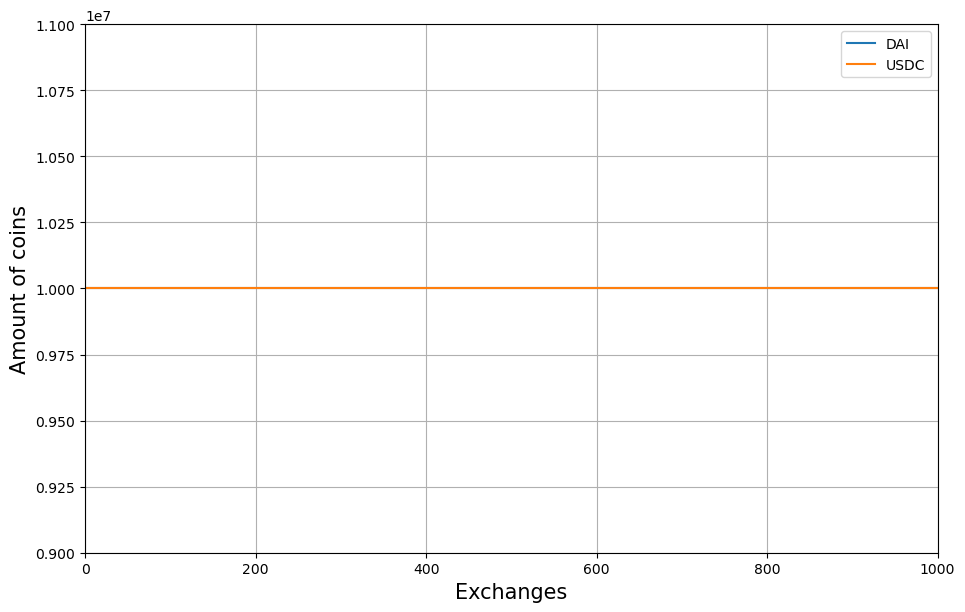

In [18]:
#Stableswap

dpi= 100
fig = plt.figure(dpi = dpi, figsize = (1100/dpi, 700/dpi))

plt.xlabel('Exchanges', fontsize=15)
plt.ylabel('Amount of coins', fontsize=15)
plt.grid()
plt.xlim(0, nrows)
plt.ylim(min(min(X1), min(X2)) - 10**6, max(max(X1), max(X2)) + 10**6)
plt.plot(range(np.size(X1)), X1, label = 'DAI')
plt.plot(range(np.size(X2)), X2, label = 'USDC')
plt.legend()


plt.show()
#fig.savefig('Test11_Stableswap_coin_amt.png')

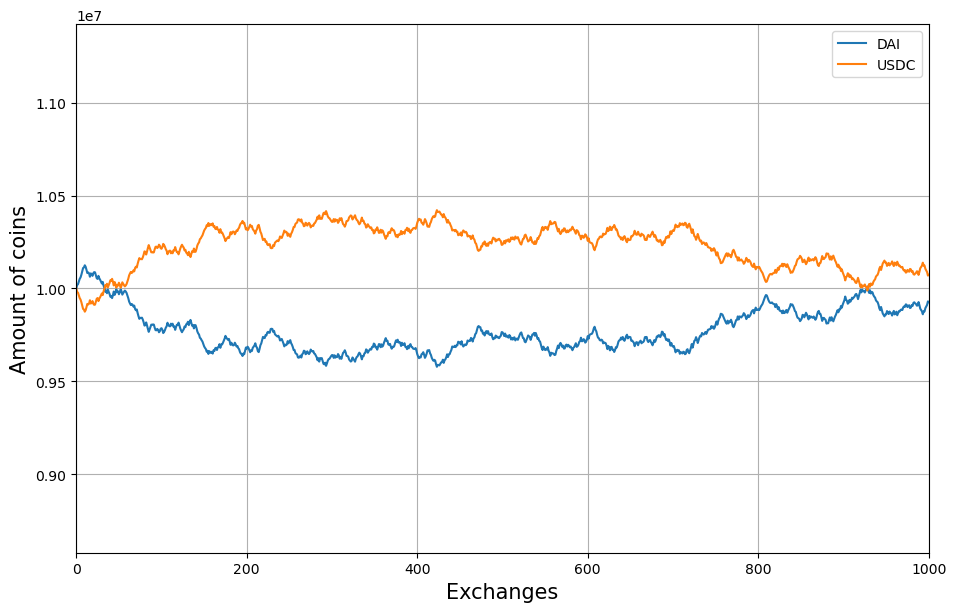

In [19]:
#UniswapV3

dpi= 100
fig = plt.figure(dpi = dpi, figsize = (1100/dpi, 700/dpi))

plt.xlabel('Exchanges', fontsize=15)
plt.ylabel('Amount of coins', fontsize=15)
plt.grid()
plt.xlim(0, nrows)
plt.ylim(min(min(U1), min(U2)) - 10**6, max(max(U1), max(U2)) + 10**6)
plt.plot(range(np.size(U1)), U1, label = 'DAI')
plt.plot(range(np.size(U2)), U2, label = 'USDC')
plt.legend()


plt.show()
#fig.savefig('Test11_Uniswap_coin_amt.png')

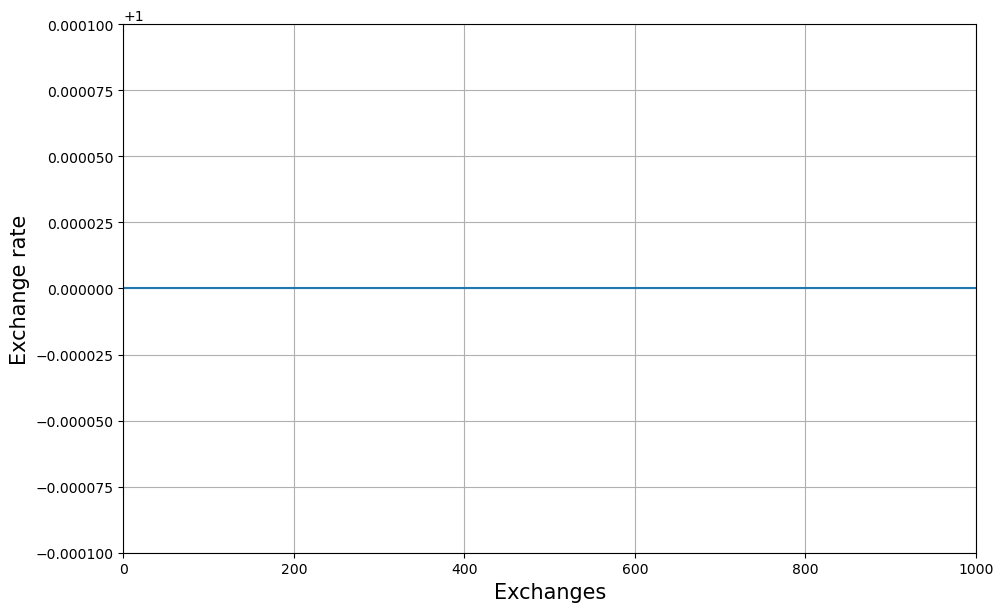

In [20]:
# ER Stableswap

dpi = 100

fig = plt.figure(dpi = dpi, figsize = (1100/dpi, 700/dpi))
x = range(np.size(Course_Stableswap))
plt.plot(x, Course_Stableswap)
plt.xlim(0, nrows)
plt.ylim(min(Course_Stableswap)- 0.0001, max(Course_Stableswap) + 0.0001)
plt.xlabel('Exchanges', fontsize=15)
plt.ylabel('Exchange rate', fontsize=15)
plt.grid()

plt.show()
#fig.savefig('Test11_ER_Stableswap.png')

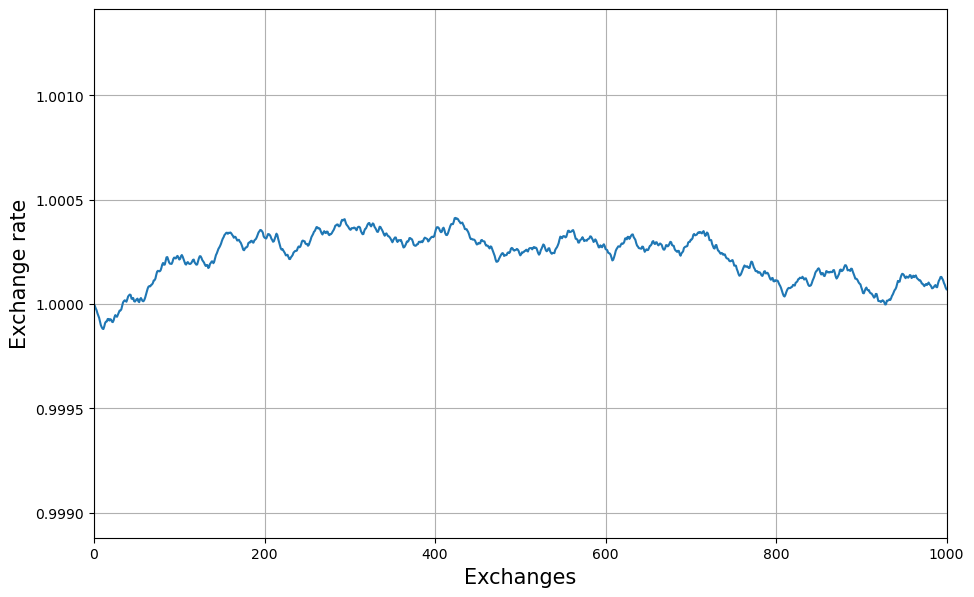

In [21]:
# ER Uniswap

dpi = 100

fig = plt.figure(dpi = dpi, figsize = (1100/dpi, 700/dpi))
#ax = fig.add_subplot(111)
x = range(np.size(Course_UniswapV3))
plt.plot(x, Course_UniswapV3)
plt.xlim(0, nrows)
plt.ylim(min(Course_UniswapV3) - 0.001, max(Course_UniswapV3) + 0.001)
plt.xlabel('Exchanges', fontsize=15)
plt.ylabel('Exchange rate', fontsize=15)
plt.grid()

plt.show()
#fig.savefig('Test11_ER_Uniswap.png')

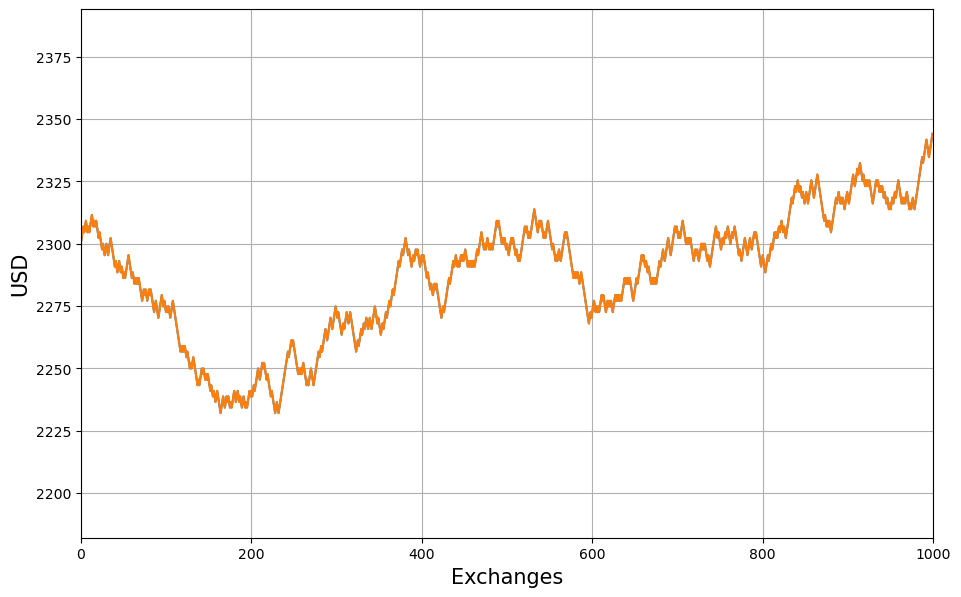

In [22]:
dpi= 100
fig = plt.figure(dpi = dpi, figsize = (1100/dpi, 700/dpi))

x = range(np.size(etc_course))
plt.plot(x, etc_course)
plt.xlim(0, nrows)
plt.ylim(min(etc_course) - 50, max(etc_course) + 50)
plt.xlabel('Exchanges', fontsize=15)
plt.ylabel('USD', fontsize=15)
plt.grid()


plt.plot(range(np.size(etc_course)), etc_course)
plt.show()
#fig.savefig('Test11_etc_course.png')

In [23]:
print(min(etc_course))
print(max(etc_course))

2232.0247271615813
2344.1177918201183


In [24]:
cnt1 = 0
cnt2 = 0
for i in range(0, 10000): 
    if b[i] == 0: cnt1 += a[i]
    else: cnt2 += a[i]

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [ ]:
print(cnt1)
print(cnt2)

In [ ]:
import math
G = np.zeros(1000)
for i in range(1,1000):
    G[i] = gas_fee(i, i, 0)

In [ ]:
dpi= 100
fig = plt.figure(dpi = dpi, figsize = (1100/dpi, 700/dpi))

x = range(np.size(G))
plt.xlim(1, 1000)
plt.plot(x, G)
plt.xlim(1, 1000)
plt.ylim(min(G) - 1, max(G) + 1)
plt.xlabel('dt, secs', fontsize=15)
plt.ylabel('USD', fontsize=15)
plt.grid()


plt.plot(range(np.size(G)), G)
plt.show()
#fig.savefig('Test10_etc_course.png')